In [6]:
import pandas as pd
#from fbprophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,KFold

# from model.seq2seq import SimpleSeq2Seq,AttentionSeq2Seq
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from make_model import Sequence

In [7]:
TEST_SIZE = 0.0001
BATCH_SIZE = 32

In [19]:
import os
data_path = '../input/prepared/years/'
files = os.listdir(data_path)
files

['2016_year.csv', '2017_year.csv', '.ipynb_checkpoints', '2015_year.csv']

In [11]:
def load_train_data(src,N=24,M=6):
    df = pd.read_csv(src,index_col=0)
    X_seq = df[df.columns[:N]]
    y_seq = df[df.columns[N:]]
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    X_train = X_seq
    y_train = y_seq
#     print(X_train.shape,y_train.shape)
    scaler_X = MinMaxScaler((0,1))
    X_train = scaler_X.fit_transform(X_train)
    scaler_y = MinMaxScaler((0,1))
    y_train = scaler_y.fit_transform(y_train)
#     print(X_train.shape,y_train.shape)
    X_train = X_train.reshape(-1,N,1)
    y_train = y_train.reshape(-1,M,1)
#     print(X_train.shape,y_train.shape)
#     print(X_test.shape,y_test.shape)
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=TEST_SIZE,random_state=11)
    y_train = y_train.reshape(-1,M)
    y_val = y_val.reshape(-1,M)
    print('train shape',X_train.shape,y_train.shape)
    print('valid shape',X_val.shape,y_val.shape)
    return X_train, X_val, y_train, y_val,[scaler_X,scaler_y]

def load_test_data(src,scaler_X=None,scaler_y=None,N=24,M=6):
    df = pd.read_csv(src,index_col=0)
    X_seq = df[df.columns[:N]]
    y_seq = df[df.columns[N:]]
    X = np.array(X_seq)
    y = np.array(y_seq)
    X = scaler_X.transform(X)
    y = scaler_y.transform(y)
    X = X.reshape(-1,N,1)
    print(X.shape,y.shape)
    return X,y
    
def get_model(code=2,N=24,M=6):
    input_shape=[N,1]
    output_shape=[M]
    depth=[4,4]
    hidden_dim=[50,50]
#     model = make_model.make_model(input_shape, output_shape, depth, hidden_dim)
    seq = Sequence(input_shape, output_shape, depth, hidden_dim)
    if code == 0:
        return seq.make_model()
    elif code == 1:
        return seq.make_model_transformer()
    elif code == 2:
        return seq.make_model_multiheads(4)

    
def test(model,X,y,name,test_epoch):
    y_hats = model.predict(X)
    from matplotlib.backends.backend_pdf import PdfPages
    pdf = PdfPages(f'{name}.pdf')
    for epoch in range(test_epoch):
        dots = []
        plt.figure(figsize=(16,14))
        index = 1
        for i in np.random.randint(0,len(y_hats),16,dtype=np.int16):
            dots.append(i)
            plt.subplot(4,4,index)
            plt.plot(y_hats[i])
            plt.plot(y[i])
            mse = mean_squared_error(y[i],y_hats[i])
            plt.title(f'mse {np.round(mse,5)}')
            plt.legend(('predict','real'))
            index = index + 1
        print(dots)
        pdf.savefig()
        plt.close()
    for epoch in range(test_epoch):
        plt.figure(figsize=(16,14))
        dots = []
        for i in range(16):
            num = 16*epoch + i
            dots.append(num)
    #         print(num)
            plt.subplot(4,4,i+1)
            plt.plot(y_hats[num])
            plt.plot(y[num])
            mse = mean_squared_error(y[num],y_hats[num])
            plt.title(f'mse {np.round(mse,5)}')
            plt.legend(('predict','real'))
            index = index + 1
        print(dots)
        pdf.savefig()
        plt.close()
    pdf.close()
    
def get_trained_model(train_src,train_epoch,N=24,M=6):
    X_train, X_val, y_train, y_val,scalers = load_train_data(train_src,N=N,M=M)
    model = get_model(N=N,M=M)
    name = f'{train_src.split(".")[0].split("_")[-2].split("/")[-1]}_year_{N}_{M}'
    model.compile(loss='mse', optimizer='adam')
#     model.fit(X_train,y_train,epochs=train_epoch,batch_size=BATCH_SIZE,validation_data=(X_val,y_val),callbacks=[TensorBoard(log_dir=f'./log_dir/{name}/'),EarlyStopping(patience=10)])
    model.fit(X_train,y_train,epochs=train_epoch,batch_size=BATCH_SIZE,validation_split=0.2,verbose=1,callbacks=[TensorBoard(log_dir=f'./log_dir/{name}/'),EarlyStopping(patience=10)])
    model.save_weights(f'{train_src.split(".")[0].split("_")[-2].split("/")[-1]}_year.h5')
    return model,scalers
    
def one_cross_train_test(model,scalers,train_src,test_src,train_epoch=1,test_epoch=15,N=24,M=6):
    print(N,M)
    X_test, y_test = load_test_data(test_src,scaler_X=scalers[0],scaler_y = scalers[1],N=N,M=M)
    
    name = f'{train_src.split(".")[0].split("_")[-2].split("/")[-1]}_{test_src.split(".")[0].split("_")[-2].split("/")[-1]}_{[N,M]}'
    print(name)
    
    test(model,X_test,y_test,name,test_epoch=test_epoch)

def year_test():
    for N in [20,24,28]:
        for M in [6,8,10,12]:
            data_path = f'scripts/input/prepared/years/{N}_{M}/'
            files = os.listdir(data_path)
            print(files)
            for train_file in files[1:]:
                model,scalers = get_trained_model(f'{data_path}{train_file}',train_epoch=120,N=N,M=M)
                for test_file in files[1:]:
                    one_cross_train_test(model,scalers,f'{data_path}{train_file}',f'{data_path}{test_file}',N=N,M=M)

In [10]:
# one_cross_train_test(f'{data_path}2016_year.csv',f'{data_path}2015_year.csv')
# year_test()

In [49]:
np.array(continus_test['X']).shape,np.array(continus_test['y']).shape

((10, 24, 1), (10, 6))

In [15]:
# X_seq.head(1)
# y_seq.head(1)

In [3]:
# model = AttentionSeq2Seq(input_shape=(N,1), hidden_dim=24, 
#                          output_length=M, output_dim=1,depth=1,
#                          dropout=0.3,bidirectional=False)
# model = get_model()
# from keras.utils import plot_model
# plot_model(model,'model.png')
# model.summary()

In [124]:
_,_,_,_,scalers = load_train_data(src=f'{data_path}2015_year.csv')
X,y = load_test_data(src=f'{data_path}2017_year.csv',scaler_X=scalers[0],scaler_y = scalers[1])
def c_test(X,y,pdf,lag=6,start=100):
    continus_test = {'X':[],'y':[]}
    for i in range(10):
        continus_test['X'].append(X[start+i*lag])
        continus_test['y'].append(y[start+i*lag])
    model = get_model(code=0,N=24,M=6)
    model.load_weights('result/simple/2015_year.h5')
    continus_test['yhat'] = model.predict(np.array(continus_test['X']))
    
    real = list(X[start].reshape(-1))
    for item in continus_test['y']:
        real = np.concatenate((real,item))
   
    metrics = {'mse':[], 'mape':[]}
    for i in range(len(continus_test['y'])):
        metrics['mse'].append(MSE(continus_test['y'][i],continus_test['yhat'][i]))
        metrics['mape'].append(MAPE(continus_test['y'][i],continus_test['yhat'][i]))
    mse = np.round(np.mean(metrics['mse']),5)
    mape = np.round(np.mean(metrics['mape']),5)
    plt.figure(figsize=(16,5))
    plt.plot(date[start:start+24+lag*10],real,color='b',label='real')
    index = 0
    for yhat in continus_test['yhat']:
        x = [i for i in range(start+24+index*lag,start+24+(index+1)*lag)]
        x = date[x]
        plt.plot(x,continus_test['yhat'][index],label=f'predict_{index}')
        index = index + 1
#     plt.show()
    plt.title(f'mse: {mse}, mape: {mape}')
    pdf.savefig()
    plt.show()
    plt.close()

from sklearn.metrics import mean_squared_error as MSE
def MAPE(y_true, y_pred):
    """
    参数:
    y_true -- 测试集目标真实值
    y_pred -- 测试集目标预测值
    
    返回:
    mape -- MAPE 评价指标
    """
    
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred)/y_true))/n*100
    return mape

train shape (8730, 24, 1) (8730, 6)
valid shape (1, 24, 1) (1, 6)
(8732, 24, 1) (8732, 6)


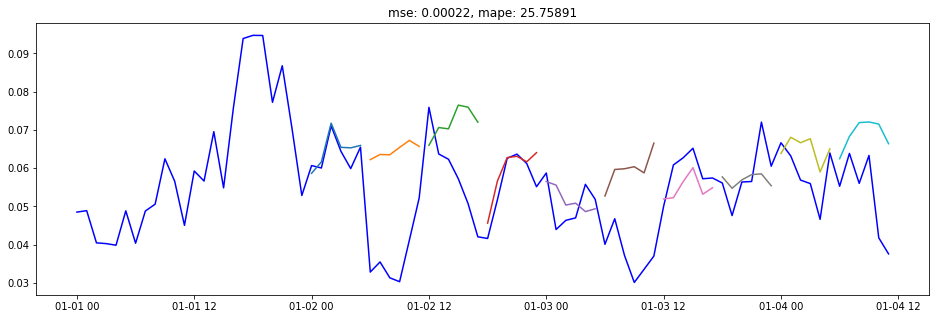

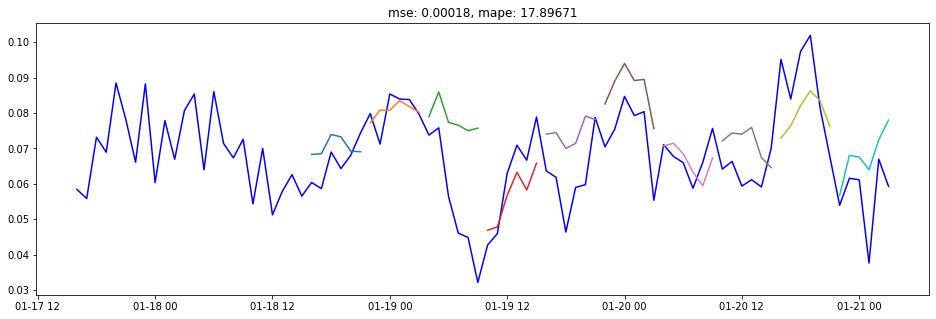

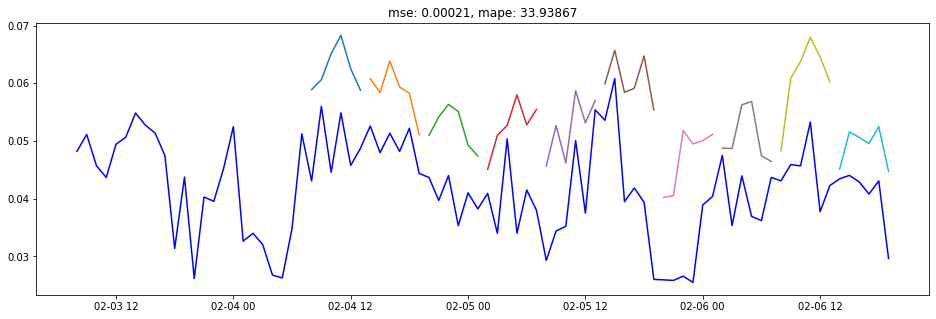

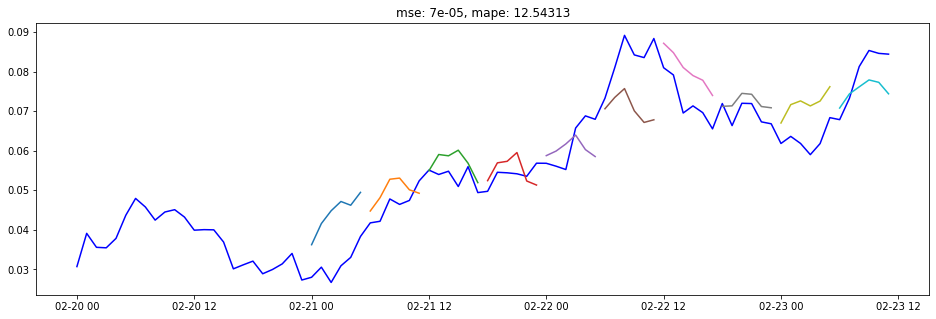

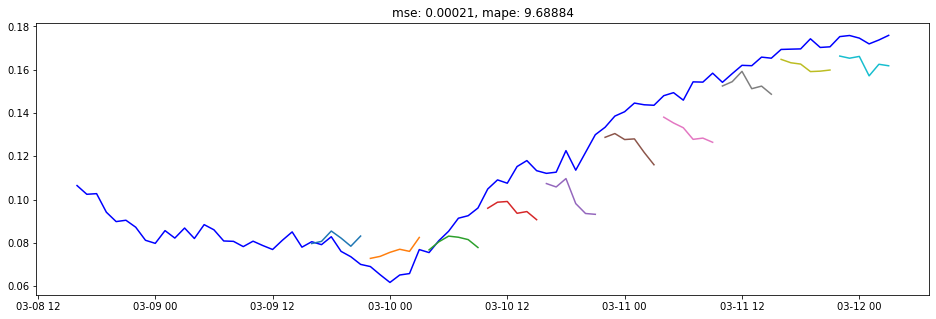

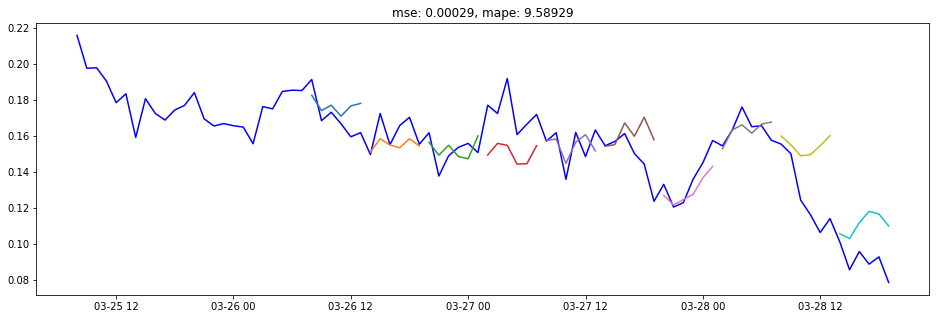

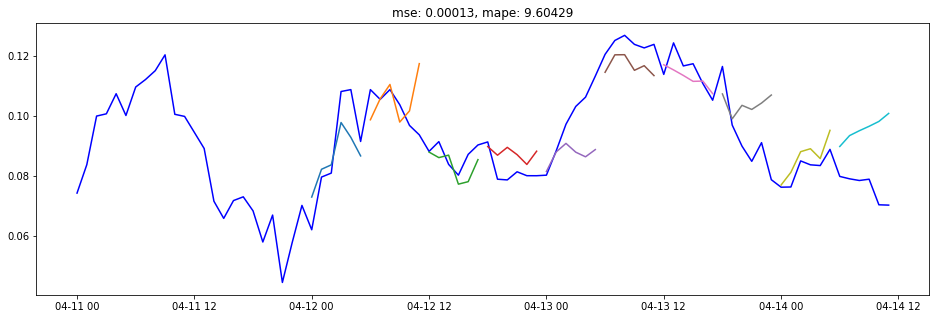

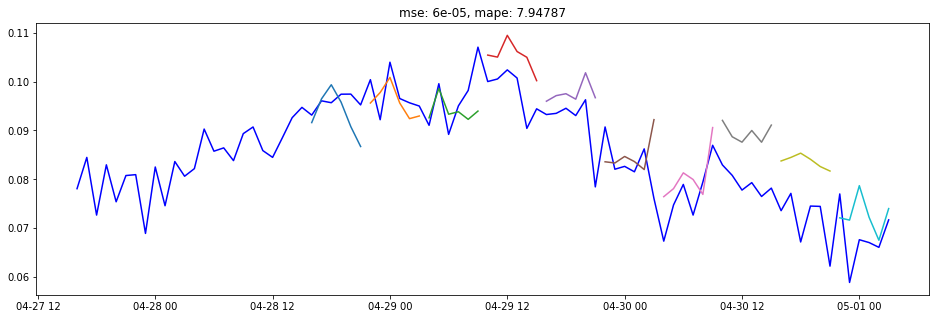

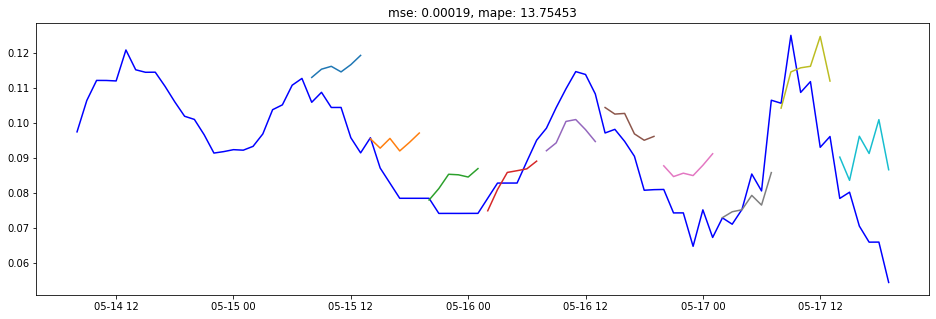

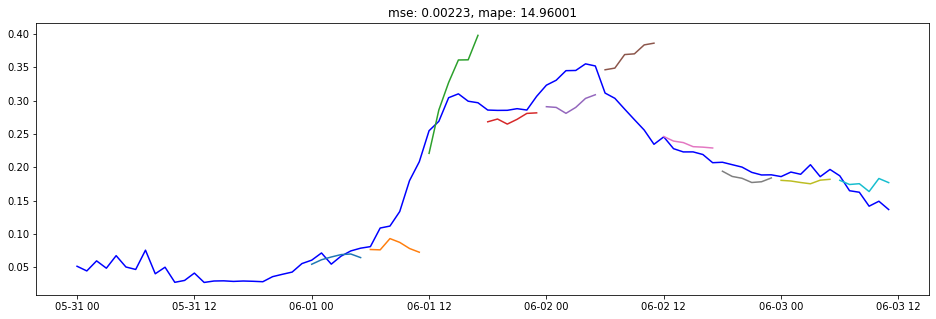

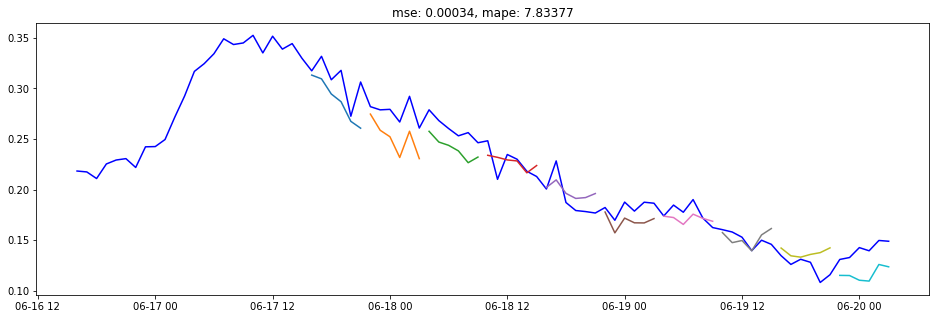

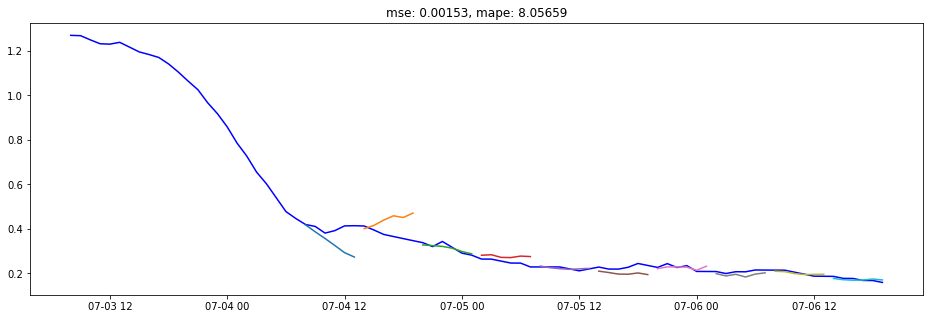

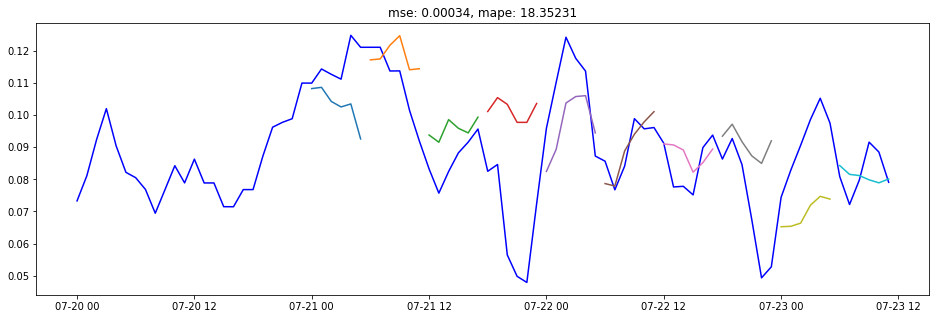

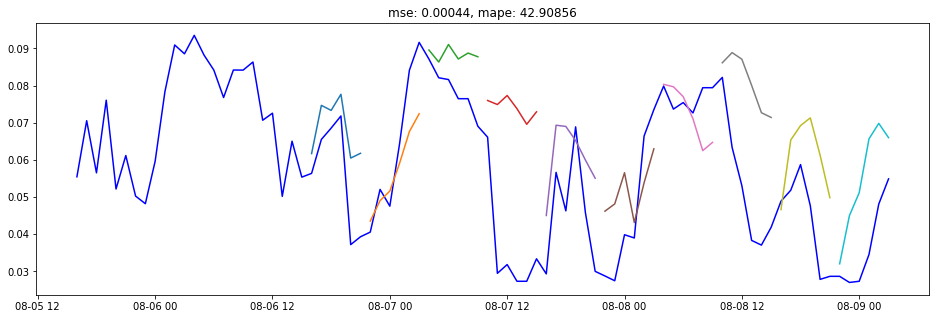

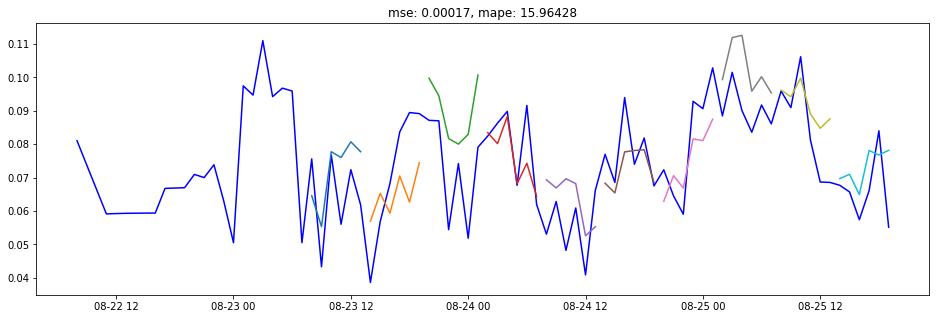

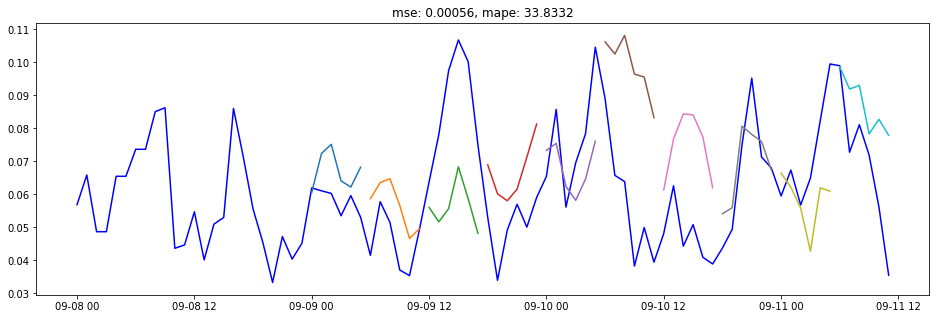

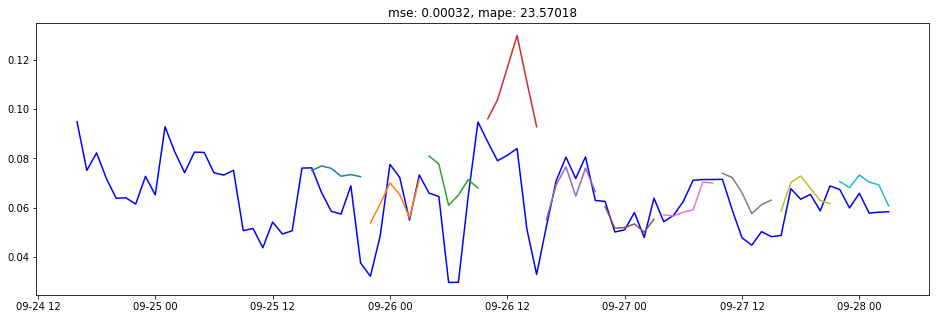

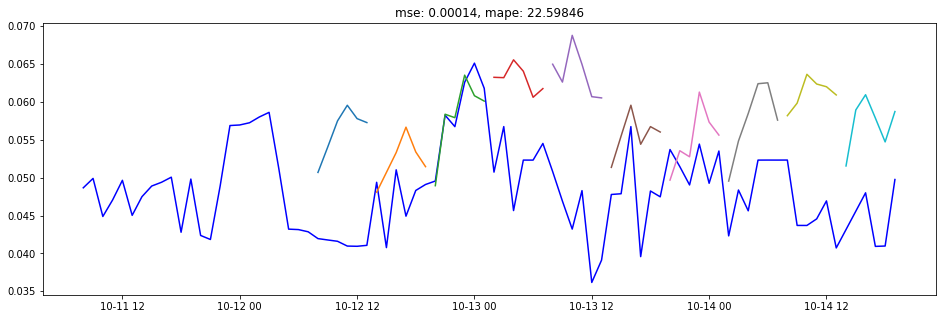

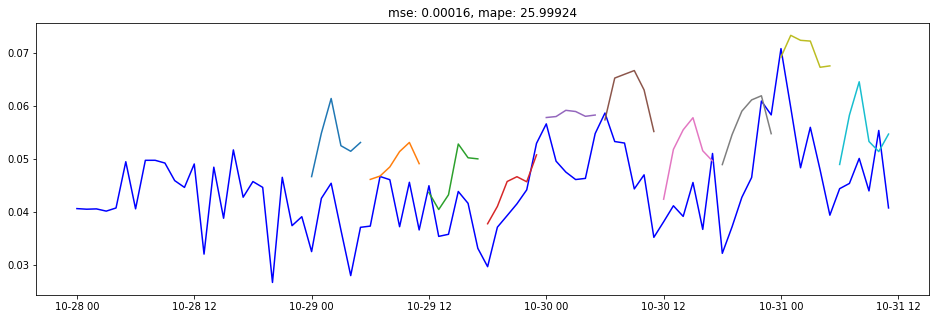

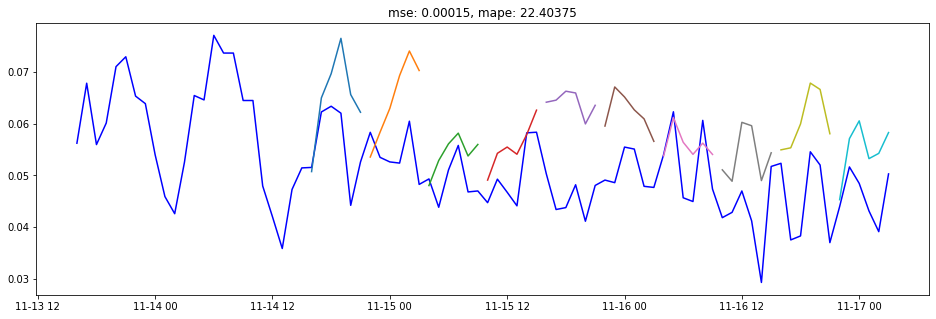

In [125]:
from matplotlib.backends.backend_pdf import PdfPages
pdf = PdfPages('test.pdf')
date = pd.date_range(start='2017/01/01 0:00:00',end='2017/12/31 23:00:00',freq='h')
for i in range(0,8000,400):
    c_test(X,y,pdf,start=i)
pdf.close()

In [84]:
_,_,_,_,scalers = load_train_data(src=f'{data_path}2015_year.csv')
X,y = load_test_data(src=f'{data_path}2016_year.csv',scaler_X=scalers[0],scaler_y = scalers[1])
continus_test = {'X':[],'y':[]}
lag = 6
start = 400
# continus_test['X'].append(X[start])
for i in range(10):
    continus_test['X'].append(X[start+i*lag])
    continus_test['y'].append(y[start+i*lag])

train shape (8730, 24, 1) (8730, 6)
valid shape (1, 24, 1) (1, 6)
(8751, 24, 1) (8751, 6)


In [117]:
model = get_model(code=1,N=24,M=6)
model.load_weights('result/transformer/2015_year.h5')
continus_test['yhat'] = model.predict(np.array(continus_test['X']))

Tensor("input_86:0", shape=(?, 24, 1), dtype=float32) Tensor("dense_98/Relu:0", shape=(?, 6), dtype=float32)


In [86]:
real = list(X[start].reshape(-1))
for item in continus_test['y']:
    real = np.concatenate((real,item))

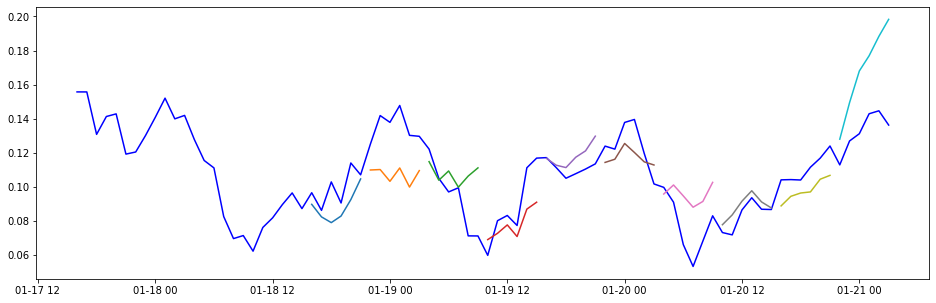

In [102]:
plt.figure(figsize=(16,5))
plt.plot(date[start:start+24+lag*10],real,color='b')
index = 0
for yhat in continus_test['yhat']:
    x = [i for i in range(start+24+index*lag,start+24+(index+1)*lag)]
    x = date[x]
    plt.plot(x,continus_test['yhat'][index])
    index = index + 1

In [103]:
# !tensorboard --logdir ./log_dir  --port 8999

In [104]:
# # plt.figure(figsize=(24,24))
# # y_hats = model.predict(X_val)
# index = 1
# plt.figure(figsize=(16,14))
# for i in np.random.randint(0,1308,16,dtype=np.int16):
#     y_hat = y_hats[i]
#     y_hat = y_hat.reshape(-1)
#     y = y_val[i].reshape(-1)
#     plt.subplot(4,4,index)
#     plt.plot(y_hat)
#     plt.plot(y)
#     mse = mean_squared_error(y,y_hat)
#     plt.title(f'mse {np.round(mse,5)}')
#     plt.legend(('predict','real'))
#     index = index + 1
# plt.show()

In [83]:
y_hats = model.predict(X)
from matplotlib.backends.backend_pdf import PdfPages
pdf = PdfPages('2015_2016.pdf')
for epoch in range(100):
    dots = []
    plt.figure(figsize=(16,14))
    index = 1
    for i in np.random.randint(0,len(y_hats),16,dtype=np.int16):
        dots.append(i)
        plt.subplot(4,4,index)
        plt.plot(y_hats[i])
        plt.plot(y[i])
        mse = mean_squared_error(y[i],y_hats[i])
        plt.title(f'mse {np.round(mse,5)}')
        plt.legend(('predict','real'))
        index = index + 1
    print(dots)
    pdf.savefig()
    plt.close()
for epoch in range(len(y_hats)//16):
    plt.figure(figsize=(16,14))
    dots = []
    for i in range(16):
        dots.append(num)
        num = 16*epoch + i
#         print(num)
        plt.subplot(4,4,i+1)
        plt.plot(y_hats[num])
        plt.plot(y[num])
        mse = mean_squared_error(y[num],y_hats[num])
        plt.title(f'mse {np.round(mse,5)}')
        plt.legend(('predict','real'))
        index = index + 1
    print(dots)
    pdf.savefig()
    plt.close()
pdf.close()